# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: 

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

In [4]:
training_set.describe()

,x1,x2,y
count,2000.000000,2000.000000,2000.00000
mean,0.844608,5.864061,0.40000
std,4.051899,2.593666,0.49002
min,-7.659203,-1.219830,0.00000
25%,-2.897422,4.160386,0.00000
50%,1.251215,5.859231,0.00000
75%,4.565506,7.664301,1.00000
max,8.612389,13.614355,1.00000


## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

### Note re: colors
- to be consistent, Class/Label = 0 is black and Class/Label = 1 is red, throughout the entire exercise, including in the open question at the end where we generate our own data with 2 classes. 

## Histograms:

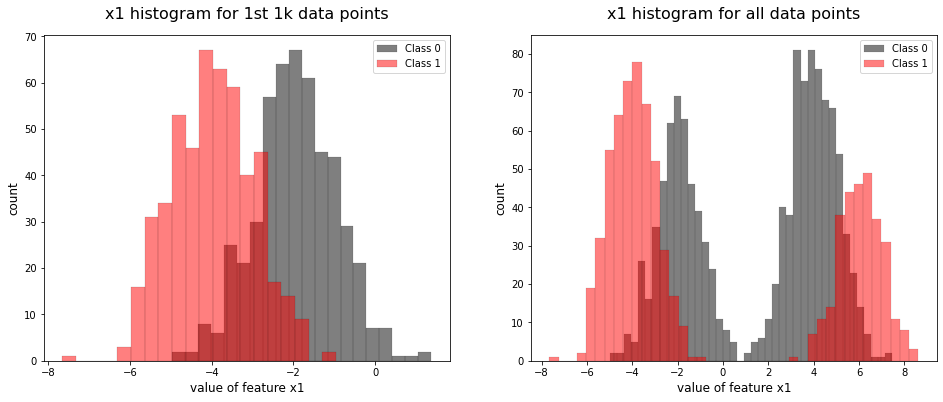

In [5]:
c0_1k, c1_1k = training_set[:1000][training_set.y == 0], training_set[:1000][training_set.y == 1]
c0, c1 = training_set[training_set.y == 0], training_set[training_set.y == 1]

# Histograms: 

fig, ax = plt.subplots(1,2,figsize=(16,6));
ax[0].hist(c0_1k[['x1']], bins=20, alpha=0.5, edgecolor='k', linewidth=0.2, color='k')
ax[0].hist(c1_1k[['x1']], bins=20, alpha=0.5, edgecolor='k', linewidth=0.2, color='r')
ax[0].legend(labels=('Class 0', 'Class 1'))
ax[0].set_title('x1 histogram for 1st 1k data points', fontsize=16, y=1.03)
ax[0].set_xlabel('value of feature x1', fontsize=12)
ax[0].set_ylabel('count', fontsize=12)
ax[1].hist(c0[['x1']], bins=40, alpha=0.5, edgecolor='k', linewidth=0.15, color='k')
ax[1].hist(c1[['x1']], bins=40, alpha=0.5, edgecolor='k', linewidth=0.15, color='r')
ax[1].legend(labels=('Class 0', 'Class 1'))
ax[1].set_title('x1 histogram for all data points', fontsize=16, y=1.03)
ax[1].set_xlabel('value of feature x1', fontsize=12)
ax[1].set_ylabel('count', fontsize=12)

plt.show();


## Scatter Plots:

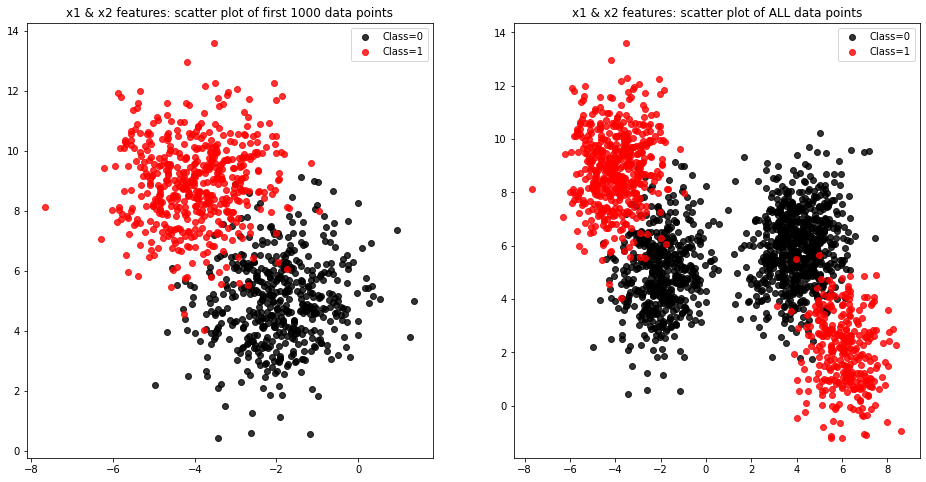

In [6]:
# Scatter Plots: 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0].scatter(data=c0_1k, x='x1', y='x2', alpha=0.8, label='Class 0', color='k')
ax[0].scatter(data=c1_1k, x='x1', y='x2', alpha=0.8, label='Class 1', color='r')

ax[1].scatter(data=c0, x='x1', y='x2', alpha=0.8, label='Class 0', color='k')
ax[1].scatter(data=c1, x='x1', y='x2', alpha=0.8, label='Class 1', color='r')

ax[0].set_title('x1 & x2 features: scatter plot of first 1000 data points')
ax[1].set_title('x1 & x2 features: scatter plot of ALL data points')

ax[0].legend(labels=('Class=0', 'Class=1'))
ax[1].legend(labels=('Class=0', 'Class=1'))

plt.show();

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [7]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        
        self.theta = None 
        self.J_history = []
        self.m = None 

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """

        X = np.column_stack((np.ones(X.shape[0]), X)) # add bias column to X_array
        self.m = X.shape[0] # m instances
        np.random.seed(seed=self.random_state)
        self.theta = np.random.random(X.shape[1])
        self.J_history = []

        loss_chg = float('inf')
        iters = 1
    
        while loss_chg >= self.eps and iters <= self.n_iter: # stop at chg < eps or n_iter
            self.J_history.append(self.compute_cost(X, y, self.theta))   
            h = self.sigmoid(X @ self.theta)
            self.theta -= (self.eta / self.m) * X.T @ (h - y) # choosing mean(ie /m) vs sum method

            if iters > 1: 
                loss_chg = abs(self.J_history[iters - 1] - self.J_history[iters - 2]) # account for diff indexes

            iters += 1 
    
    def predict(self, X):
        """Return the predicted class label"""
        X = np.column_stack((np.ones(X.shape[0]), X)) # add bias column to X_array
        return np.round(self.sigmoid(X @ self.theta)) # >0.5: class 1, <0.5: class 0 
        
    def sigmoid(self, theta_x):
        sig_exp = np.exp(theta_x)
        return sig_exp / (1 + sig_exp)
        
    def compute_cost(self, X, y, theta):
        h = self.sigmoid(X @ theta)
#         J = np.mean(((-y) @ np.log(h)) - ((1 - y) @ np.log(1 - h)))
        J = (1 / self.m) * (((-y) @ np.log(h)) - ((1 - y) @ np.log(1 - h))) # chg from np.mean saved immense time

        return J

In [8]:
# %%time
# # # LR model tests
# model = LogisticRegressionGD(eta=0.05,eps=0.01)
# model.fit(X_training, y_training)
# test_pred = model.predict(X_test)
# print(f'LR accuracy = {np.mean(test_pred == y_test):.2%}\n')

In [9]:
def cross_validate(dataset,k=5):
#### Your code here ####
# really wanted to vectorize this fcn & loops per piazza discussion, to no real avail 🤦 
# slowness might be due to slowness of each LoR run (which could be @ vs. np.dot?)

    etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
    epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
    shuffled = dataset.sample(frac=1)
    fold_size = dataset.shape[0] // k
    best_eta, best_eps = None, None
    accuracy_dict = {}
    for eta in etas:
        for eps in epss:
            accuracy_fold = []
            for i in range(0, dataset.shape[0], fold_size):
                x_train_folds = pd.concat((shuffled[['x1','x2']][0:i], shuffled[['x1','x2']][i + fold_size:]))
                y_train_folds = pd.concat((shuffled.y[0:i], shuffled.y[i + fold_size:]))
                x_val_fold, y_val_fold = shuffled[['x1','x2']][i:i + fold_size], shuffled.y[i:i + fold_size]
                classifier = LogisticRegressionGD(eta=eta,eps=eps)
                classifier.fit(x_train_folds.values, y_train_folds.values)
                prediction = classifier.predict(x_val_fold.values)

                accuracy_fold.append(np.mean(prediction == y_val_fold.values))
            accuracy_dict[eta,eps] = np.mean(accuracy_fold)
            print(f'Average {k}-fold accuracy for eta={eta}, eps={eps}: {np.mean(accuracy_fold):.2%}')    
    
    best_eta, best_eps = sorted(accuracy_dict, key=accuracy_dict.get, reverse=True)[0] 

    return best_eta, best_eps


In [10]:
%%time
best_eta, best_eps = cross_validate(training_set,5)
print('Optimized Hyperparamaters:\n', '='*40, f'\nbest eta = {best_eta:.6f}, best eps = {best_eps:.6f}\n')

Average 5-fold accuracy for eta=0.05, eps=0.01: 49.45%
Average 5-fold accuracy for eta=0.05, eps=0.001: 54.90%
Average 5-fold accuracy for eta=0.05, eps=0.0001: 56.85%
Average 5-fold accuracy for eta=0.05, eps=1e-05: 65.05%
Average 5-fold accuracy for eta=0.05, eps=1e-06: 78.90%
Average 5-fold accuracy for eta=0.005, eps=0.01: 39.30%
Average 5-fold accuracy for eta=0.005, eps=0.001: 52.40%
Average 5-fold accuracy for eta=0.005, eps=0.0001: 52.25%
Average 5-fold accuracy for eta=0.005, eps=1e-05: 56.25%
Average 5-fold accuracy for eta=0.005, eps=1e-06: 64.95%
Average 5-fold accuracy for eta=0.0005, eps=0.01: 37.75%
Average 5-fold accuracy for eta=0.0005, eps=0.001: 39.25%
Average 5-fold accuracy for eta=0.0005, eps=0.0001: 53.80%
Average 5-fold accuracy for eta=0.0005, eps=1e-05: 51.95%
Average 5-fold accuracy for eta=0.0005, eps=1e-06: 56.15%
Average 5-fold accuracy for eta=5e-05, eps=0.01: 37.75%
Average 5-fold accuracy for eta=5e-05, eps=0.001: 37.75%
Average 5-fold accuracy for eta=

## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [11]:
#### Your code here ####
def norm_pdf(data, mu, sigma):
    """
    Calculate normal density function (pdf) for the given data, mu and sigma.   
    """
    return 1 / (sigma * ((2 * np.pi) ** 0.5)) * np.exp(-0.5 * (((data - mu) / sigma) ** 2)) 

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

<div style="max-width:450px;margin-left: 5; margin-right: 10;">
    
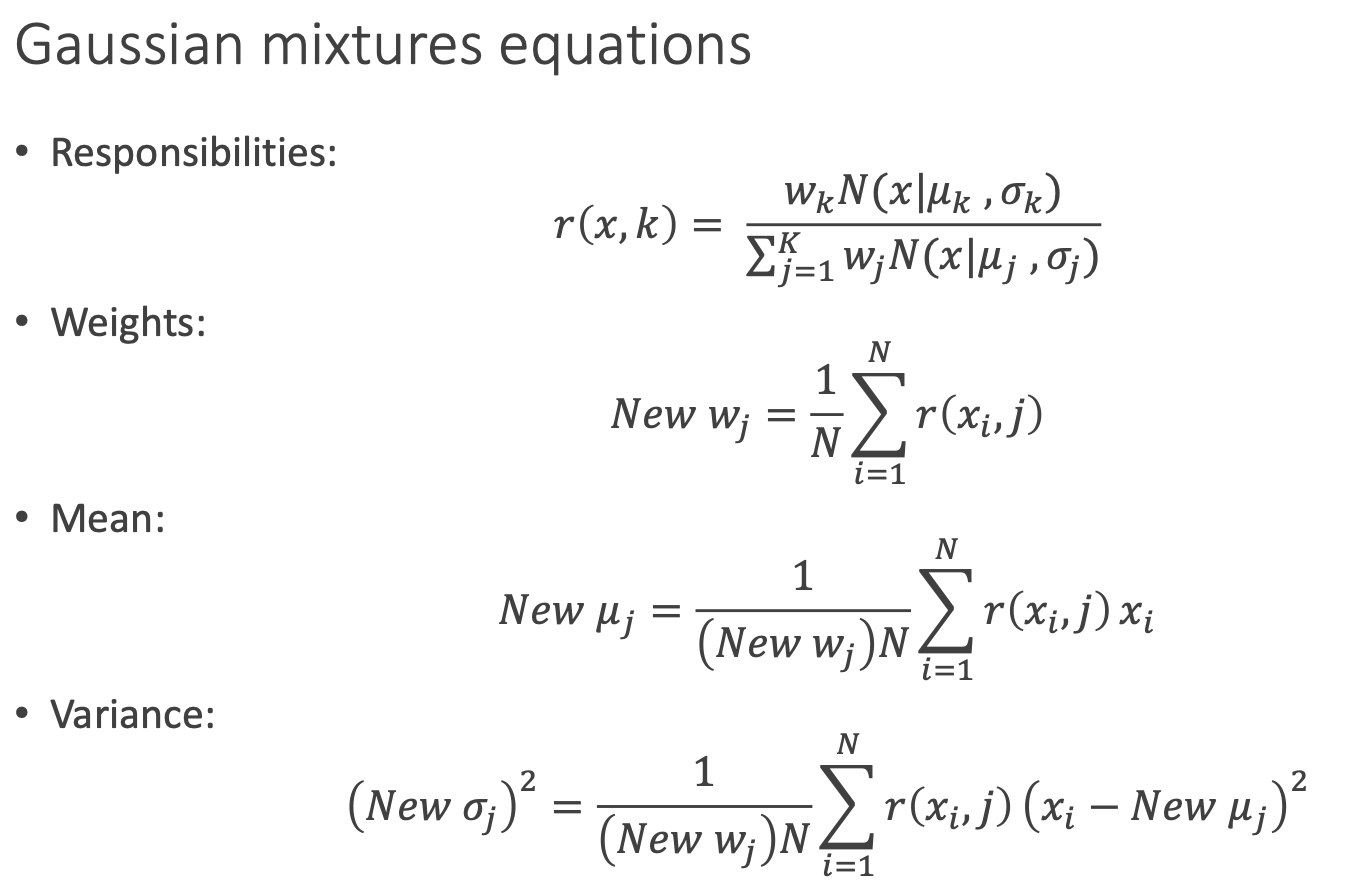
    
</div>

In [12]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.dist_params = {}
        self.likelihoods = None
        self.resp_arr = None
        self.ws = None

    def init_params(self, data):
        """
        Initialize distribution params
        """
        # for init_params, chose to split data and take mean/std of each chunk as starting est's
        chunks = data.shape[0] // self.k
        
        for dist in range(self.k):
            data_chunk = data[dist * chunks : (dist+1) * chunks]
            self.dist_params[dist] = {'w': 1 / self.k, 'mu': data_chunk.mean(), 'std': data_chunk.std()}
   
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        # create array of GMM likelihoods, accdg to: pdf_GMM = pdf_G1 * w1 + pdf_G2 * w2
        self.likelihoods = [norm_pdf(data, self.dist_params[dist]['mu'], self.dist_params[dist]['std']) 
                            * self.dist_params[dist]['w'] for dist in range(self.k)]
        
        # create responsibilty array dividing likelihoods by sum of likelihoods across instances/rows
        self.resp_arr = self.likelihoods / np.sum(self.likelihoods, axis=0) 

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        # M-step is sum of dot_product of vector of values @ resp) divided by new_w * N aka mean / new_w
        new_stds = None 
        self.ws = np.mean(self.resp_arr, axis=1)
        for dist in range(self.k): # update params accdg to formulas above
            self.dist_params[dist]['w'] = self.ws[dist] 
            self.dist_params[dist]['mu'] = np.mean(self.resp_arr[dist] * data) / self.ws[dist]
            self.dist_params[dist]['std'] = (np.mean(self.resp_arr[dist] * 
                                            ((data - self.dist_params[dist]['mu']) ** 2)) / self.ws[dist]) ** 0.5
            
    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        
        # iterate EM until converge to cost_chg < epsilon or reach n_iter 
        self.init_params(data) # initialize params for underlying Gaussians
        
        prev_cost = 0
        cost_delta = float('inf')
        iters = 1

        while cost_delta >= self.eps and iters <= self.n_iter:
            # calculate responsibilites
            self.expectation(data)

            # update the current distribution params
            self.maximization(data)

            # calculate cost of params
            cost = np.sum(-np.log2(self.likelihoods)) # a sum of sums (1 sum > 1 Gauss, sum(sums) > GMM)
            cost_delta = abs(cost - prev_cost)

            prev_cost = cost
            iters += 1
    
    def get_dist_params(self):
        return self.dist_params
    

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [13]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k
        self.gaussians = {} # nested dict of dist_params per label per feature
        self.prior = []
        self.classes = []
        self.features = [] # number of features

    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        self.gaussians = {}
        self.features = X.shape[1]
        self.classes = list(np.unique(y))
        self.prior = [len(y[[y == label]]) / y.shape[0] for label in self.classes]
        
        for label in range(len(self.classes)): # switched to len to deal with floats later on
            self.gaussians[label] = {} # initiate nested dictionary for gauss params per label (& per feature)
            for feature in range(self.features):
                model_feature = EM(k=self.k)
                model_feature.fit(X[y == label, feature]) # fit data filtered for class value 
                self.gaussians[label][feature] = model_feature.get_dist_params()
        
    def gmm_pdf(self, k, data, gaussian_params):
        gmm_likelihoods = np.zeros((np.shape(data)[0], k))
        for dist in range(k):
            w, mu, std = gaussian_params[dist]['w'], gaussian_params[dist]['mu'], gaussian_params[dist]['std']
            gmm_likelihoods[:,dist] = np.multiply(norm_pdf(data, mu, std), w)
        return np.sum(gmm_likelihoods, axis=1)
                
    def predict(self, X):
        """Return the predicted class label"""
        # create table to populate posterior probabilities per instance
        # posterior_P(Ai|x) = instance_likelihood_P(x|Ai) * prior_P(Ai) # Bayes' Theorem
        # simplifying the math >> log(P(x|Ai)) + log(P(Ai))
        
        posterior_table = np.zeros((X.shape[0],len(self.classes)))
        for label in range(len(self.classes)):
            posterior_table[:, label] += np.log(self.prior[label]) # add log(prior) to entire class columns
            for feature in range(self.features):
                feature_likelihood = self.gmm_pdf(self.k, X[:, feature], self.gaussians[label][feature])
                posterior_table[:, label] += np.log(feature_likelihood) # add log(likelihood)
                
        return np.argmax(posterior_table, axis=1) # return higher of P(A1|X), P(A2|X)

In [14]:
# %%time
# # EM / NB model tests
# modell = EM(k=2)
# modell.fit(X_training[y_training==0][:,1])
# modell.get_dist_params()
# modellnb = NaiveBayesGaussian(k=2)
# modellnb.fit(X_training, y_training)
# modellnb.gaussians
# modellnb.predict(X_test)
# np.mean(modellnb.predict(X_test) == y_test)

# # np.sum(np.sum(-np.log2(modell.likelihoods), axis=1))
# # np.sum(-np.log2(modell.likelihoods))

# # emm.fit(training_set.loc[training_set['y'] == 0, 'x1'].values)
# # emm.get_dist_params()

## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

## First 1000 training points and first 500 test points:

In [15]:
%%time
#### Your code here ####
X_train_1k, y_train_1k = X_training[:1000], y_training[:1000]
X_test_500, y_test_500 = X_test[:500], y_test[:500]

# Logistic Regression:
model_lr = LogisticRegressionGD(eta=best_eta, eps=best_eps) # Fit LoR model with best params you found earlier
model_lr.fit(X_train_1k, y_train_1k)

prediction_lr_train = model_lr.predict(X_train_1k)
prediction_lr_test = model_lr.predict(X_test_500)

accuracy_lr_train = np.mean(prediction_lr_train == y_train_1k)
accuracy_lr_test = np.mean(prediction_lr_test == y_test_500)

print('Logistic Regression Model Accuracies (First 1000/500 Points): \n', '='*40, '\n')
print(f'LoR Training Accuracy: {accuracy_lr_train:.2%}\n')
print(f'LoR Test Accuracy: {accuracy_lr_test:.2%}')

# Naive Bayes:
model_nb = NaiveBayesGaussian(k=2)
model_nb.fit(X_train_1k, y_train_1k)

prediction_nb_train = model_nb.predict(X_train_1k)
prediction_nb_test = model_nb.predict(X_test_500)

accuracy_nb_train = np.mean(prediction_nb_train == y_train_1k)
accuracy_nb_test = np.mean(prediction_nb_test == y_test_500)

print('Naive Bayes Model Accuracies (First 1000/500 Points): \n', '='*40, '\n')
print(f'Naive Bayes Training Accuracy: {accuracy_nb_train:.2%}\n')
print(f'Naive Bayes Test Accuracy: {accuracy_nb_test:.2%}\n\n')

Logistic Regression Model Accuracies (First 1000/500 Points): 

LoR Training Accuracy: 96.50%

LoR Test Accuracy: 93.80%
Naive Bayes Model Accuracies (First 1000/500 Points): 

Naive Bayes Training Accuracy: 96.80%

Naive Bayes Test Accuracy: 94.20%


CPU times: user 617 ms, sys: 2.34 ms, total: 619 ms
Wall time: 618 ms


## Decision Boundary Graphs:

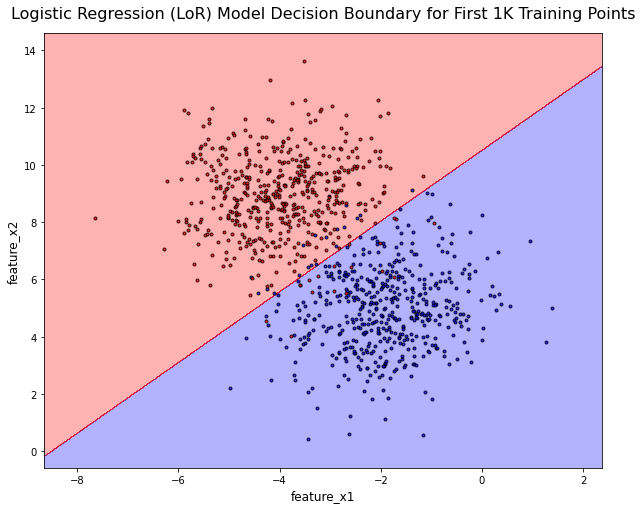

In [16]:
plot_decision_regions(X_train_1k, y_train_1k, model_lr)
plt.title('Logistic Regression (LoR) Model Decision Boundary for First 1K Training Points', fontsize=16, y=1.02)
plt.xlabel('feature_x1', fontsize=12)
plt.ylabel('feature_x2', fontsize=12)
plt.show();

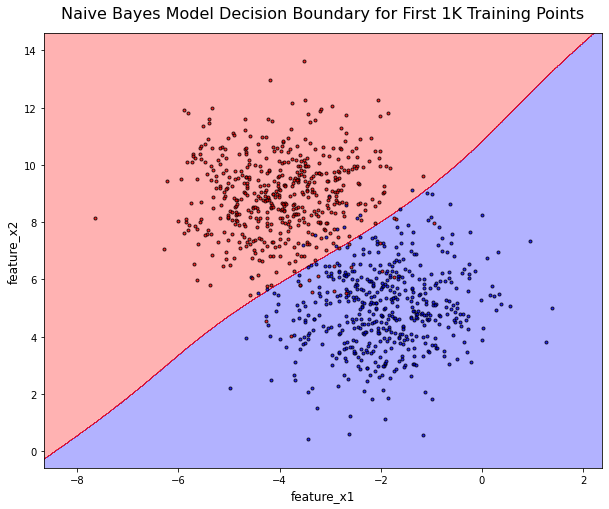

CPU times: user 604 ms, sys: 31.8 ms, total: 636 ms
Wall time: 634 ms


In [17]:
%%time
plot_decision_regions(X_train_1k, y_train_1k, model_nb)
plt.title('Naive Bayes Model Decision Boundary for First 1K Training Points', fontsize=16, y=1.02)
plt.xlabel('feature_x1', fontsize=12)
plt.ylabel('feature_x2', fontsize=12)
plt.show();

## Cost vs. Iterations Graph for LoR:

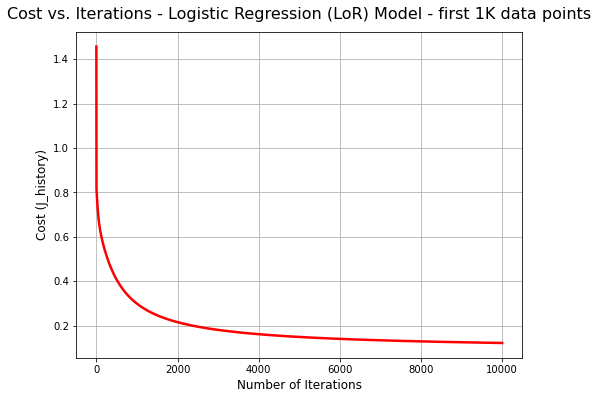

In [18]:
plt.figure(figsize=(8,6))
plt.plot(model_lr.J_history, color='r', linewidth=2.5)
plt.title('Cost vs. Iterations - Logistic Regression (LoR) Model - first 1K data points', fontsize=16, y=1.02)
plt.xlabel('Number of Iterations', fontsize=12)
plt.ylabel('Cost (J_history)', fontsize=12)
plt.grid()
plt.show();

## Commentary on Graphs for First 1000/500 Points: 

**Decision Region Graphs:**
- As we clearly observed in the scatter plots (& histograms) at the beginning of the exercise, this dataset happens to be split in a way that almost perfectly divides the underlying distributions in the data, i.e. we had 2 "blobs" in the first scatter plot of the first 1000 training points, and 4 "blobs" in the scatter plot of all training data. This split lends itself to very good separability of the classes, be it linearly with LoR or with Naive Bayes & EM. This also aligns with the training & test accuracies of ~97% and 94%, respectively, observed for both LoR and NB. 

**Cost vs. Iterations Graph:**
- This cost/loss vs. iterations graph looks very solid and is what you hope to see, and aligns well with the very high observed accuracies (LoR in this case). There is a very steep cost improvement up front where >50% of the improvement seems to happen in the first few hundred iterations (at most), and certainly 75-80% or more of the improvement is achieved in under 1000 iterations. 


## All the training set points:

In [31]:
#### Your code here ####

# Logistic Regression:
model_lr_all = LogisticRegressionGD(eta=best_eta, eps=best_eps) # Fit LoR model with best params you found earlier
model_lr_all.fit(X_training, y_training)

prediction_lr_train_all = model_lr_all.predict(X_training)
prediction_lr_test_all = model_lr_all.predict(X_test)

accuracy_lr_train_all = np.mean(prediction_lr_train_all == y_training)
accuracy_lr_test_all = np.mean(prediction_lr_test_all == y_test)

print('Logistic Regression Model Accuracies (All Data): \n', '='*40, '\n')
print(f'LoR Training Accuracy: {accuracy_lr_train_all:.2%}\n')
print(f'LoR Test Accuracy: {accuracy_lr_test_all:.2%}')

# Naive Bayes:
model_nb_all = NaiveBayesGaussian(k=2)
model_nb_all.fit(X_training, y_training)

prediction_nb_train_all = model_nb_all.predict(X_training)
prediction_nb_test_all = model_nb_all.predict(X_test)

accuracy_nb_train_all = np.mean(prediction_nb_train_all == y_training)
accuracy_nb_test_all = np.mean(prediction_nb_test_all == y_test)

print('Naive Bayes Model Accuracies (All Data): \n', '='*40, '\n')
print(f'Naive Bayes Training Accuracy: {accuracy_nb_train_all:.2%}\n')
print(f'Naive Bayes Test Accuracy: {accuracy_nb_test_all:.2%}')

Logistic Regression Model Accuracies (All Data): 

LoR Training Accuracy: 79.60%

LoR Test Accuracy: 79.20%
Naive Bayes Model Accuracies (All Data): 

Naive Bayes Training Accuracy: 92.15%

Naive Bayes Test Accuracy: 90.20%


## Decision Boundary Graphs (All Data):

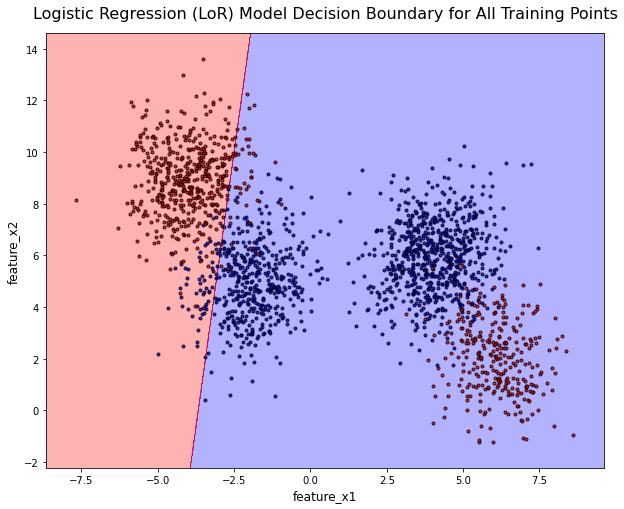

In [20]:
plot_decision_regions(X_training, y_training, model_lr_all)
plt.title('Logistic Regression (LoR) Model Decision Boundary for All Training Points', fontsize=16, y=1.02)
plt.xlabel('feature_x1', fontsize=12)
plt.ylabel('feature_x2', fontsize=12)
plt.show();

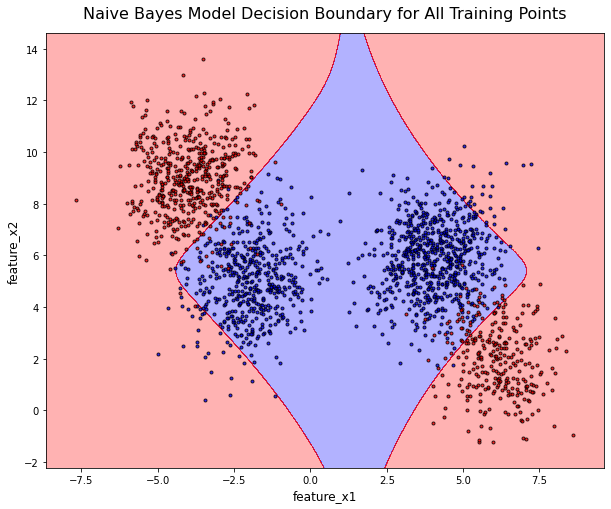

CPU times: user 1.04 s, sys: 73.6 ms, total: 1.11 s
Wall time: 1.11 s


In [21]:
%%time
plot_decision_regions(X_training, y_training, model_nb_all)
plt.title('Naive Bayes Model Decision Boundary for All Training Points', fontsize=16, y=1.02)
plt.xlabel('feature_x1', fontsize=12)
plt.ylabel('feature_x2', fontsize=12)
plt.show();

## Cost vs. Iterations Graph for LoR (All Data):

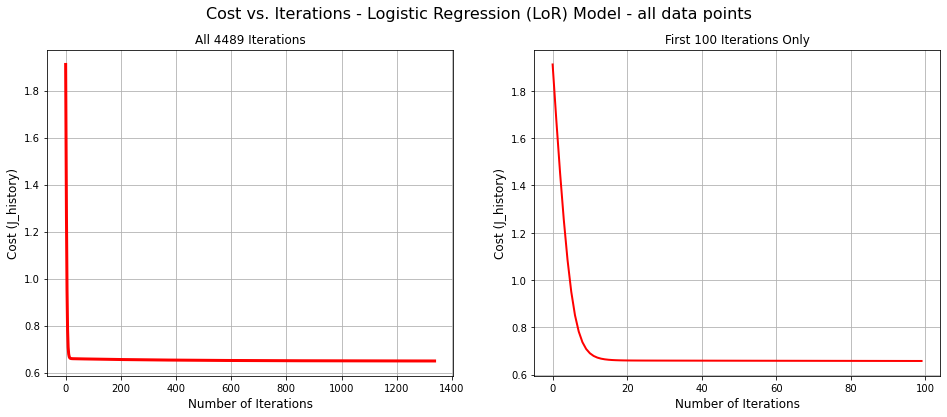

<Figure size 576x432 with 0 Axes>

In [22]:
fig, ax = plt.subplots(1,2,figsize=(16,6));
plt.figure(figsize=(8,6))
ax[0].plot(model_lr_all.J_history, color='r', linewidth=3)
ax[1].plot(model_lr_all.J_history[:100], color='r', linewidth=2)
fig.suptitle('Cost vs. Iterations - Logistic Regression (LoR) Model - all data points', fontsize=16)
ax[0].set_title('All 4489 Iterations'), ax[1].set_title('First 100 Iterations Only')
ax[0].set_xlabel('Number of Iterations', fontsize=12), ax[1].set_xlabel('Number of Iterations', fontsize=12)
ax[0].set_ylabel('Cost (J_history)', fontsize=12), ax[1].set_ylabel('Cost (J_history)', fontsize=12)
ax[0].grid(), ax[1].grid();
plt.show();

## Commentary on Graphs for All Data: 

**Decision Region Graphs:**
- As we discussed above, the full dataset clearly contained 4 "blobs", illustrating the underlying multivariate gaussian distributions for the features x1 and x2. While LoR got "lucky" with the first slice of only 1K data points which were linearly separable, that wasn't the case when it faced all four blobs. A rough eyeballing of the Decision Region / Boundary graph for LoR shows that it was likely to classify 3 of the 4 blobs correctly, since there's one red in the red region, and both blues are in the blue region. However, the 2nd more sparse red blob sits in the blue region, so a rough estimate would be 75-80% accuracy, which is indeed what we observed (~80%). 
    - note LoR accuracy was ~82% but the CV fcn took around 75 secs to run which we couldn't live with, and after much trial & error, simply changing the cost function to 1/m vs. np.mean saved us (& you the esteemed grader) tons of runtime! worth the 2 point hit to LoR accuracy here in our humble opinions :-) 


- The Naive Bayes classifier using EM on the other hand, classifies the instances based on the posterior probability, or the highest/argmax likelihood of a class given the data, which according to Bayes' Theorem uses the instance likelihood, or the gaussian mixture probability of generating that data given a class. The Naive Bayes is not limited to a simple linear separator, as can be seen clearly with diamond-ish shape around the blue class, and this allows Naive Bayes to outperform and generate accuracies of ~90-92%. 

**Cost vs. Iterations Graph:**
- We separated this graph into 2 - one for all 4,489 iterations and a second just zooming in one the first 100 iterations - in order to aid the visualization. 


- Two interesting things to note from these graphs: 
    - The starting and ending point of the cost function was much higher for the full data set compared to the first 1000 samples, which aligns with the higher error rate and lower accuracy reported for LoR for the full dataset. The LoR cost for all data started at >3,800 and ended ~1,300, compared to the first 1000 samples, where it started under 1,500 and converged to 121. 
    - The LoR classifier for all data converged **significantly** faster than that for the first 1000 samples, as it achieved >95% of its cost reduction in the first 10-20 samples alone. This also ties into it reaching its stopping condition of loss change < epsilon, resulting in only 4,489 iterations, whereas all 10,000 iterations were run for the first 1000 samples. 

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Naive Bayes will work better than Logisitc Regression**.
   2. Generate another dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Logistic Regression will work better than Naive Bayes**.
   
   - Explain the reasoning behind each dataset.  

2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

#### Your code and explanations here ####


In [23]:
from scipy.stats import multivariate_normal as mvn
def generate_mvn_samples(d, mean, samples):
    return mvn.rvs(mean=np.full(d, mean), cov=np.eye(d), size=samples, random_state=42)

d = 3 # number of features or 'dimensions'
m_tr, m_tst = 2000, 400 # m = # of samples in training (tr) and test (tst) sets

## 1A. Naive Bayes > LoR:

In [24]:
#### Your code here ####
# Naive Bayes performs better than Logistic Regression:

means = [1, 9, 25]
G = {}

for dist in range(3):
    G[dist] = generate_mvn_samples(d, means[dist], m_tr)

# assign class0 to 1st and 3rd multivar_gauss and class1 to middle mv_gauss:
train_nb = np.concatenate((np.c_[G[0], np.zeros(m_tr)], np.c_[G[1], np.ones(m_tr)], np.c_[G[2], np.zeros(m_tr)]))

G_test = {}
for dist in range(3):
    G_test[dist] = generate_mvn_samples(d, means[dist], m_tst)

test_nb = np.concatenate((np.c_[G_test[0], np.zeros(m_tst)], np.c_[G_test[1], np.ones(m_tst)], 
                          np.c_[G_test[2], np.zeros(m_tst)]))

# initiate models for "nb_better" ie Naive Bayes > LoR:
nb_better_lr = LogisticRegressionGD(eta=best_eta, eps=best_eps) 
nb_better_lr.fit(X=train_nb[:,:-1], y=train_nb[:,-1])
nb_better_nb = NaiveBayesGaussian(k=2)
nb_better_nb.fit(X=train_nb[:,:-1], y=train_nb[:,-1])

# predict class using LoR and NB classifiers
pred_nb_better_lr_train = nb_better_lr.predict(train_nb[:,:-1])
pred_nb_better_lr_test = nb_better_lr.predict(test_nb[:,:-1])
pred_nb_better_nb_train = nb_better_nb.predict(train_nb[:,:-1])
pred_nb_better_nb_test = nb_better_nb.predict(test_nb[:,:-1])

# calc accuracies:
accuracy_nb_better_lr_train = np.mean(pred_nb_better_lr_train == train_nb[:,-1])
accuracy_nb_better_lr_test = np.mean(pred_nb_better_lr_test == test_nb[:,-1])
accuracy_nb_better_nb_train = np.mean(pred_nb_better_nb_train == train_nb[:,-1])
accuracy_nb_better_nb_test = np.mean(pred_nb_better_nb_test == test_nb[:,-1])

print('Naive Bayes > LogisticRegression Model Accuracies: \n', '='*40, '\n')
print(f'LoR Accuracies: Training = {accuracy_nb_better_lr_train:.2%}\nLoR_Test = {accuracy_nb_better_lr_test:.2%}\n')
print(f'Naive Bayes Accuracies: Training = {accuracy_nb_better_nb_train:.2%}\nNB_Test = {accuracy_nb_better_nb_test:.2%}')

Naive Bayes > LogisticRegression Model Accuracies: 

LoR Accuracies: Training = 34.02%
LoR_Test = 34.17%

Naive Bayes Accuracies: Training = 100.00%
NB_Test = 100.00%


## Visualizations for NB > LoR:

### 3D Visualization - NB > LoR

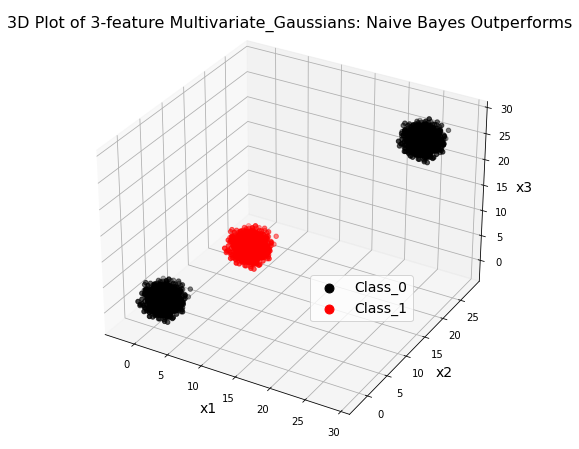

In [25]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(G[0][:,0], G[0][:,1], G[0][:,2], color='k')
ax.scatter(G[1][:,0], G[1][:,1], G[1][:,2], color='r')
ax.scatter(G[2][:,0], G[2][:,1], G[2][:,2], color='k')
ax.set_title('3D Plot of 3-feature Multivariate_Gaussians: Naive Bayes Outperforms', fontsize=16, y=1.02)
ax.set_xlabel('x1', fontsize=14), ax.set_ylabel('x2', fontsize=14), ax.set_zlabel('x3', fontsize=14)
plt.legend(labels=('Class_0', 'Class_1'), fontsize=14, markerscale=2, bbox_to_anchor=(0.5, 0.4, 0.3, 0))
plt.show()

### 2D Visualizations - NB > LoR

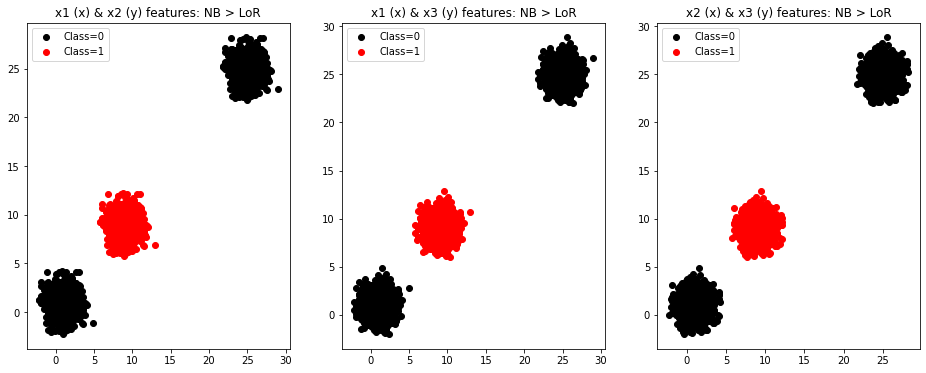

In [26]:
fig, ax = plt.subplots(1,3,figsize=(16,6));
ax[0].scatter(train_nb[train_nb[:,3] == 0, 0], train_nb[train_nb[:,3] == 0, 1], color='k')
ax[0].scatter(train_nb[train_nb[:,3] == 1, 0], train_nb[train_nb[:,3] == 1, 1], color='r')

ax[1].scatter(train_nb[train_nb[:,3] == 0, 0], train_nb[train_nb[:,3] == 0, 2], color='k')
ax[1].scatter(train_nb[train_nb[:,3] == 1, 0], train_nb[train_nb[:,3] == 1, 2], color='r')

ax[2].scatter(train_nb[train_nb[:,3] == 0, 1], train_nb[train_nb[:,3] == 0, 2], color='k')
ax[2].scatter(train_nb[train_nb[:,3] == 1, 1], train_nb[train_nb[:,3] == 1, 2], color='r')

ax[0].set_title('x1 (x) & x2 (y) features: NB > LoR')
ax[1].set_title('x1 (x) & x3 (y) features: NB > LoR')
ax[2].set_title('x2 (x) & x3 (y) features: NB > LoR')

ax[0].legend(labels=('Class=0', 'Class=1'))
ax[1].legend(labels=('Class=0', 'Class=1'))
ax[2].legend(labels=('Class=0', 'Class=1'))

plt.show();

## Commentary on Dataset with Naive Bayes Outperforming LoR:
- The reasoning behind this dataset was driven by independence / co-dependence conditions in the underlying feature distributions. For the data where Naive Bayes outperforms, we wanted the distirbutions to be independent or less co-dependent, creating data for which the classes are not linearly separable with a single hyperplane, much like what was observed in the full dataset we worked with above for the rest of the exercise. 


- Depending on the specific parameters and spreads, the linear separator (LoR) was likely to get only 1 or 2 of our 3 "blobs" classified correctly, so we'd roughly expect either 1/3 or 2/3 accuracy, and the 34% LoR accuracy confirmed that notion. This compared to the perfect accuracy of 100% for the Naive Bayes classifier with EM, on both training & test sets, which makes sense since we created data where the blobs were all very clearly separable, just not linearly. 

    - an interesting anecdote is that the accuracy of the LoR model was extremely sensitive to the values we chose for the mean array when sampling the multivariate gaussians. 


## 1B. LoR > Naive Bayes: 

In [27]:
#### Your code here ####

# Logistic Regression performs better than Naive Bayes:

means1 = [[0,5,10],[0,5,8]]
cov1 = np.array([[1,0.95,0.9],[0.95,1,0.8],[0.9,0.8,1]])
G1 = {}

for dist in range(2):
    G1[dist] = mvn.rvs(mean=means1[dist], cov=cov1, size=m_tr) 
    
# assign class0 to 1st multivar_gauss and class1 to 2nd mv_gauss:
train_lr = np.concatenate((np.c_[G1[0], np.zeros(m_tr)], np.c_[G1[1], np.ones(m_tr)]))

G1_test = {}
for dist in range(2):
    G1_test[dist] = mvn.rvs(mean=means1[dist], cov=cov1, size=m_tst)

test_lr = np.concatenate((np.c_[G1_test[0], np.zeros(m_tst)], np.c_[G1_test[1], np.ones(m_tst)]))

# initiate models for "lr_better" ie LoR > Naive Bayes:
lr_better_lr = LogisticRegressionGD(eta=best_eta, eps=best_eps) 
lr_better_lr.fit(X=train_lr[:,:-1], y=train_lr[:,-1])
lr_better_nb = NaiveBayesGaussian(k=2)
lr_better_nb.fit(X=train_lr[:,:-1], y=train_lr[:,-1])

# predict class using LoR and NB classifiers
pred_lr_better_lr_train = lr_better_lr.predict(train_lr[:,:-1])
pred_lr_better_lr_test = lr_better_lr.predict(test_lr[:,:-1])
pred_lr_better_nb_train = lr_better_nb.predict(train_lr[:,:-1])
pred_lr_better_nb_test = lr_better_nb.predict(test_lr[:,:-1])

# calc accuracies:
accuracy_lr_better_lr_train = np.mean(pred_lr_better_lr_train == train_lr[:,-1])
accuracy_lr_better_lr_test = np.mean(pred_lr_better_lr_test == test_lr[:,-1])
accuracy_lr_better_nb_train = np.mean(pred_lr_better_nb_train == train_lr[:,-1])
accuracy_lr_better_nb_test = np.mean(pred_lr_better_nb_test == test_lr[:,-1])

print('Logistic Regression > Naive Bayes Model Accuracies: \n', '='*40, '\n')
print(f'LoR Accuracies: Training = {accuracy_lr_better_lr_train:.2%}\nLoR_Test = {accuracy_lr_better_lr_test:.2%}\n')
print(f'Naive Bayes Accuracies: Training = {accuracy_lr_better_nb_train:.2%}\nNB_Test = {accuracy_lr_better_nb_test:.2%}')

Logistic Regression > Naive Bayes Model Accuracies: 

LoR Accuracies: Training = 91.60%
LoR_Test = 91.62%

Naive Bayes Accuracies: Training = 84.50%
NB_Test = 84.38%


## Visualizations for LoR > NB:

### 3D Visualization - LoR > NB

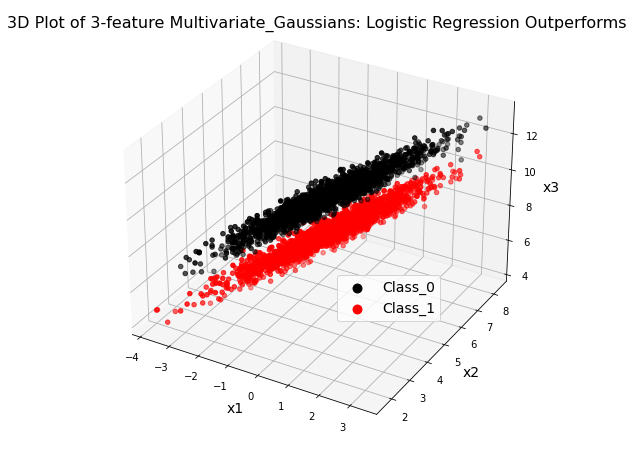

In [28]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(G1[0][:,0], G1[0][:,1], G1[0][:,2], color='k')
ax.scatter(G1[1][:,0], G1[1][:,1], G1[1][:,2], color='r')
ax.set_title('3D Plot of 3-feature Multivariate_Gaussians: Logistic Regression Outperforms', fontsize=16, y=1.02)
ax.set_xlabel('x1', fontsize=14), ax.set_ylabel('x2', fontsize=14), ax.set_zlabel('x3', fontsize=14)
plt.legend(labels=('Class_0', 'Class_1'), fontsize=14, markerscale=2, bbox_to_anchor=(0.5, 0.4, 0.3, 0))
plt.show()

### 2D Visualizations - NB > LoR

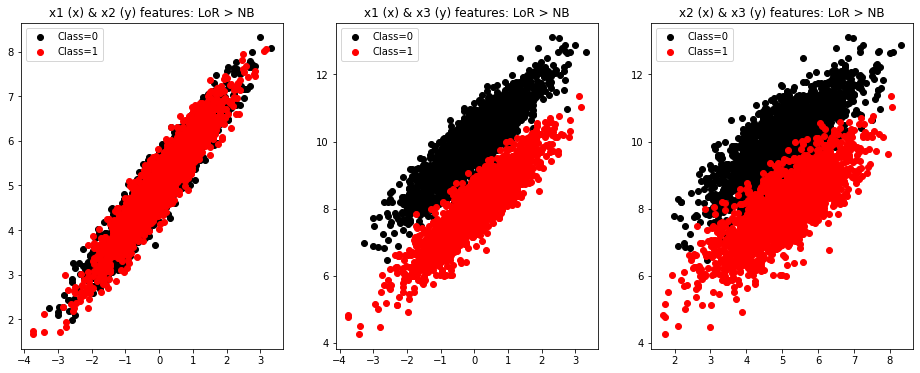

In [29]:
fig, ax = plt.subplots(1,3,figsize=(16,6));
ax[0].scatter(train_lr[train_lr[:,3] == 0, 0], train_lr[train_lr[:,3] == 0, 1], color='k')
ax[0].scatter(train_lr[train_lr[:,3] == 1, 0], train_lr[train_lr[:,3] == 1, 1], color='r')

ax[1].scatter(train_lr[train_lr[:,3] == 0, 0], train_lr[train_lr[:,3] == 0, 2], color='k')
ax[1].scatter(train_lr[train_lr[:,3] == 1, 0], train_lr[train_lr[:,3] == 1, 2], color='r')

ax[2].scatter(train_lr[train_lr[:,3] == 0, 1], train_lr[train_lr[:,3] == 0, 2], color='k')
ax[2].scatter(train_lr[train_lr[:,3] == 1, 1], train_lr[train_lr[:,3] == 1, 2], color='r')

ax[0].set_title('x1 (x) & x2 (y) features: LoR > NB')
ax[1].set_title('x1 (x) & x3 (y) features: LoR > NB')
ax[2].set_title('x2 (x) & x3 (y) features: LoR > NB')

ax[0].legend(labels=('Class=0', 'Class=1'))
ax[1].legend(labels=('Class=0', 'Class=1'))
ax[2].legend(labels=('Class=0', 'Class=1'))

plt.show();

## Commentary on 2nd Dataset with LoR Outperforming Naive Bayes: 
- The reasoning behind this dataset was also all driven by independence / co-dependence conditions in the underlying feature distributions. It was all about the covariance matrix, in which we created conditions that exhibit high co-dependence, correlations, and covariances, which made the classes much more clearly linearly separable, favoring the LoR classifier. The Naive Bayes classifier has a flaw in this case as it assumes independence between the features (allowing us to take the product of probabilities), and this assumption is clearly not correct in this scenario we created. 


- We used only 2 multivariate gaussian distributions for this dataset to keep it simpler, and set the means to be very close to but not quite equal to each other, with high covariances as mentioned above. This can be clearly seen visually above as the two class blobs move together in lock-step up and to the right. 


- The observed accuracies for this setup were around 92% for LoR compared to roughly 84% for Naive Bayes. 